In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import theano

from scipy.special import logsumexp

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 6.1

In [2]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


#### Code 6.2

In [3]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [4]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

0.4901580479490839

#### Code 6.4

In [5]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [6]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [7]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [8]:
d_new = d.drop(d.index[-1])

#### Code 6.8

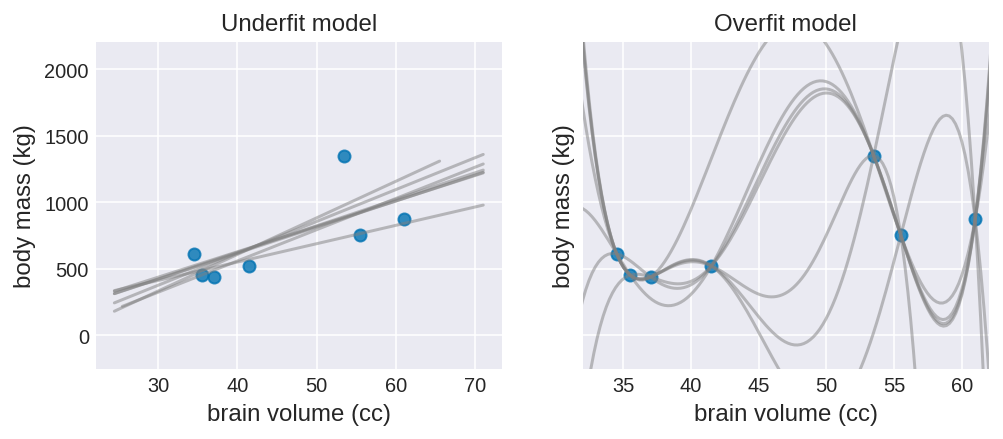

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

An example will help to demystify the function H(p). To compute the information en-
tropy for the weather, suppose the true probabilities of rain and shine are p 1 = 0.3 and
p 2 = 0.7, respectively. Then:aaa

In [10]:
p = (0.3, 0.7)
-sum(p * np.log(p))

0.6108643020548935

Suppose instead we live in Abu Dhabi. Then the probabilities of rain and shine might be more
like p 1 = 0.01 and p 2 = 0.99. Now the entropy would be

In [11]:
p = (0.01, 0.99)
-sum(p * np.log(p))

0.056001534354847345

Why has the uncertainty decreased? Because in Abu Dhabi it hardly ever rains. Therefore there’s much less uncertainty about any given day, compared to a place in which it rains 30% of the time. It’s in this way that information entropy measures the uncertainty inherent in a distribution of events. Similarly, if we add another kind of event to the distribution—forecasting into winter, so also predicting snow—entropy tends to increase, due the added dimensionality of the prediction problem. For example, suppose probabilities of sun, rain, and snow are
p 1 = 0.7, p 2 = 0.15, and p 3 = 0.15, respectively. Then entropy is 

In [12]:
p = (0.7, 0.15, 0.15)
-sum(p * np.log(p))

0.818808456222877

These entropy values by themselves don’t mean much to us, though. Instead we can use them to build a measure of accuracy.

The only trick in computing H is to deal with the inevitable question of what to do when p i = 0.
The log(0) = −∞, which won’t do. However, L’Hôpital’s rule tells us that lim p i →0 p i log(p i ) = 0. So
just assume that 0 log(0) = 0, when you compute H. In other words, events that never happen drop
out. This is not really a trick. It follows from the definition of a limit. But it isn’t obvious. It may make
more sense to just remember that when an event never happens, there’s no point in keeping it in the
model.

#### Code 6.10

In [13]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.92498968588757

#### Code 6.11

In [14]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(2000, tune=5000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:12<00:00, 1151.34draws/s]


In [15]:
theta = pm.summary(m_6_8)['mean'][:3]

In [16]:
#compute deviance
dev = - 2 * sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1] * d['mass_s']  , scale = theta[2]))
dev 

100.57045391243871

#### Code 6.12

[This](https://github.com/rmcelreath/rethinking/blob/a309712d904d1db7af1e08a76c521ab994006fd5/R/sim_train_test.R) is the original function.

In [17]:
# This function only works with number of parameters >= 2 

def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
    
    mm_train = np.ones((N,1))
    
    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)
    
    #Using pymc3
    
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(n_dim), 
                            shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample()
        
    vec = pm.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    
    dev_train = - 2 * sum(stats.norm.logpdf(x_train, loc = np.matmul(x_train, vec), scale = 1))    
    
    mm_test = np.ones((N,1))
    
    mm_test = np.concatenate([mm_test, x_test[:, 1:k +1]], axis=1)
    
    dev_test = - 2 * sum(stats.norm.logpdf(x_test[:,0], loc = np.matmul(mm_test, vec), scale = 1))    
    
    return np.mean(dev_train), np.mean(dev_test)

In [18]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j -2, :] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 681.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 582.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 520.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 712.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████|

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 572.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 637.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 679.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 712.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████|

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 683.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 634.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 705.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 553.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████|

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 703.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 763.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 704.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 711.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████|

6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 735.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 799.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 690.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 796.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████|

#### Code 6.14

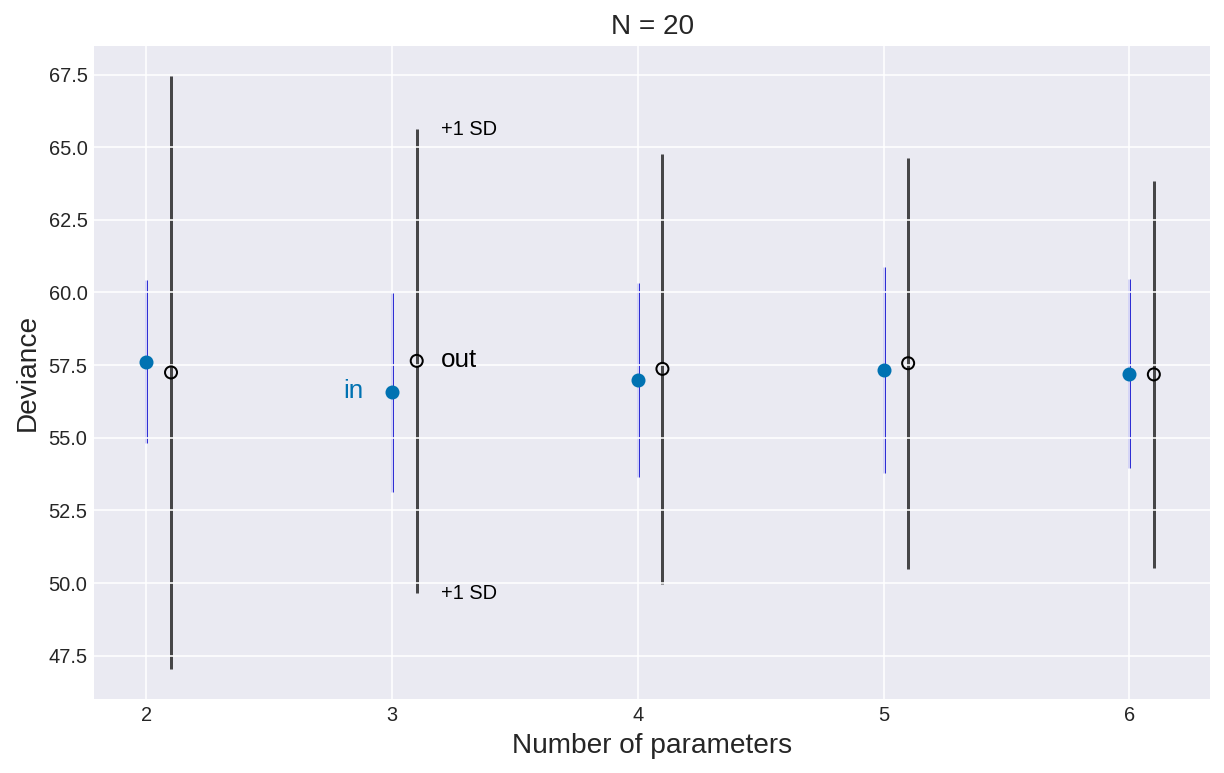

In [19]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color='C0')
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='mediumblue', 
               zorder=-1, alpha=0.80)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.70)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=14)
plt.ylabel('Deviance', fontsize=14)
plt.title('N = {}'.format(n), fontsize=14)
plt.show()

#### Code 6.15

In [20]:
data = pd.read_csv('Data/cars.csv', sep=',')

In [21]:
with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:36<00:00, 813.34draws/s]


#### Code 6.16

In [22]:
n_samples = 1000
n_cases = data.shape[0]
ll = np.zeros((n_cases, n_samples))

compute the likelihood of $y_{i}$ for each set of parameters sampled from the posterior
distribution.

In [23]:
for s in range(0, n_samples):
    mu = m_6_15['a'][s] + m_6_15['b'][s] * data['speed']
    p_ = stats.norm.logpdf(data['dist'], loc=mu, scale=m_6_15['sigma'][s])
    ll[:,s] = p_

#### Code 6.17

Then we average the likelihoods for each observation i

In [24]:
n_cases = data.shape[0]
lppd = np.zeros((n_cases))
for a in range(1, n_cases):
    lppd[a,] = logsumexp(ll[a,]) - np.log(n_samples)

#### Code 6.18

The second piece of WAIC is the effective number of parameters p WAIC . Calcualte the variance in log-likelihood for observation i in the training sample. This means we compute the log-likelihood of y i for each sample from the posterior distribution. Then we take the variance of those values

In [25]:
pWAIC = np.zeros((n_cases))
for i in range(1, n_cases):
    pWAIC[i,] = np.var(ll[i,])

#### Code 6.19

In [26]:
- 2 * (sum(lppd) - sum(pWAIC))

412.1882576131565

#### Code 6.20

In [27]:
waic_vec = - 2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

14.983837419752403

#### Code 6.21

In [28]:
d = pd.read_csv('Data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

(17, 9)

#### Code 6.22

In [29]:
a_start = d['kcal.per.g'].mean()
sigma_start = d['kcal.per.g'].std()

In [30]:
mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(1000, tune=1000)    

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    mu = alpha + beta * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(5000, tune=15000)
    
with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta * mass_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta[0] * mass_shared + beta[1] * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(5000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1571.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 40000/40000 [02:33<00:00, 261.36draws/s]
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6550431986817453, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100

#### Code 6.23

In [31]:
pm.waic(trace_m6_14, m6_14)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-17.036858323470664, WAIC_se=4.9480818117313055, p_WAIC=3.016396324617391, var_warn=1)

#### Code 6.24

In [32]:

compare_df = pm.compare({m6_11 : trace_m6_11,
                         m6_12 : trace_m6_12,
                         m6_13 : trace_m6_13,
                         m6_14 : trace_m6_14}, method='pseudo-BMA')

compare_df.loc[:,'model'] = pd.Series(['m6.11', 'm6.12', 'm6.13', 'm6.14'])
compare_df = compare_df.set_index('model')
compare_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6.14,-17.04,3.02,0,0.96,4.95,0,1
m6.13,-9,1.94,8.04,0.02,3.99,3.33,1
m6.11,-8.72,1.33,8.32,0.02,3.62,4.68,0
m6.12,-7.13,1.91,9.91,0.01,3.05,4.76,0


#### Code 6.25

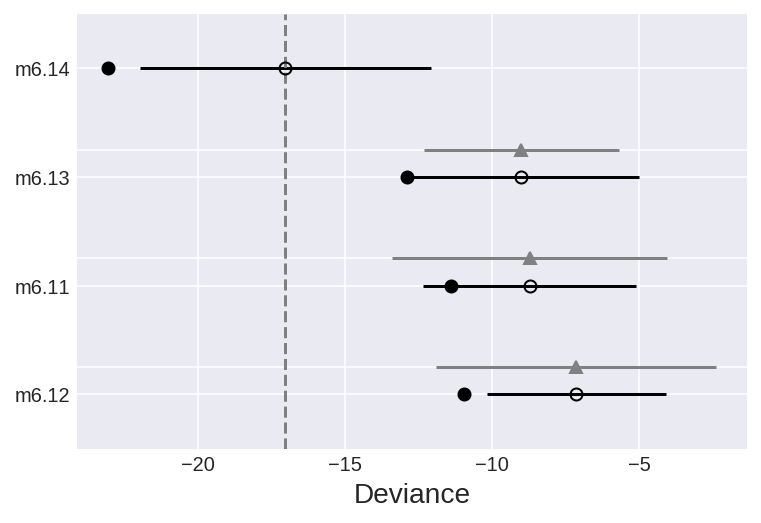

In [33]:
pm.compareplot(compare_df);

#### Code 6.26

In [34]:
diff = np.random.normal(loc=6.7, scale=7.26, size=100000)
sum(diff[diff<0]) / 100000

-0.70617466670607

#### Code 6.27

Compare function already checks number of observations to be equal.

In [35]:
coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

,m6_11,m6_12,m6_13,m6_14
alpha,0.657486,0.343275,0.703769,-1.052589
beta,NaN,0.464688,-0.031626,NaN
beta__0,NaN,NaN,NaN,-0.094658
beta__1,NaN,NaN,NaN,2.740510
sigma,0.187534,0.195508,0.184610,0.139009


#### Code 6.28

In [36]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]

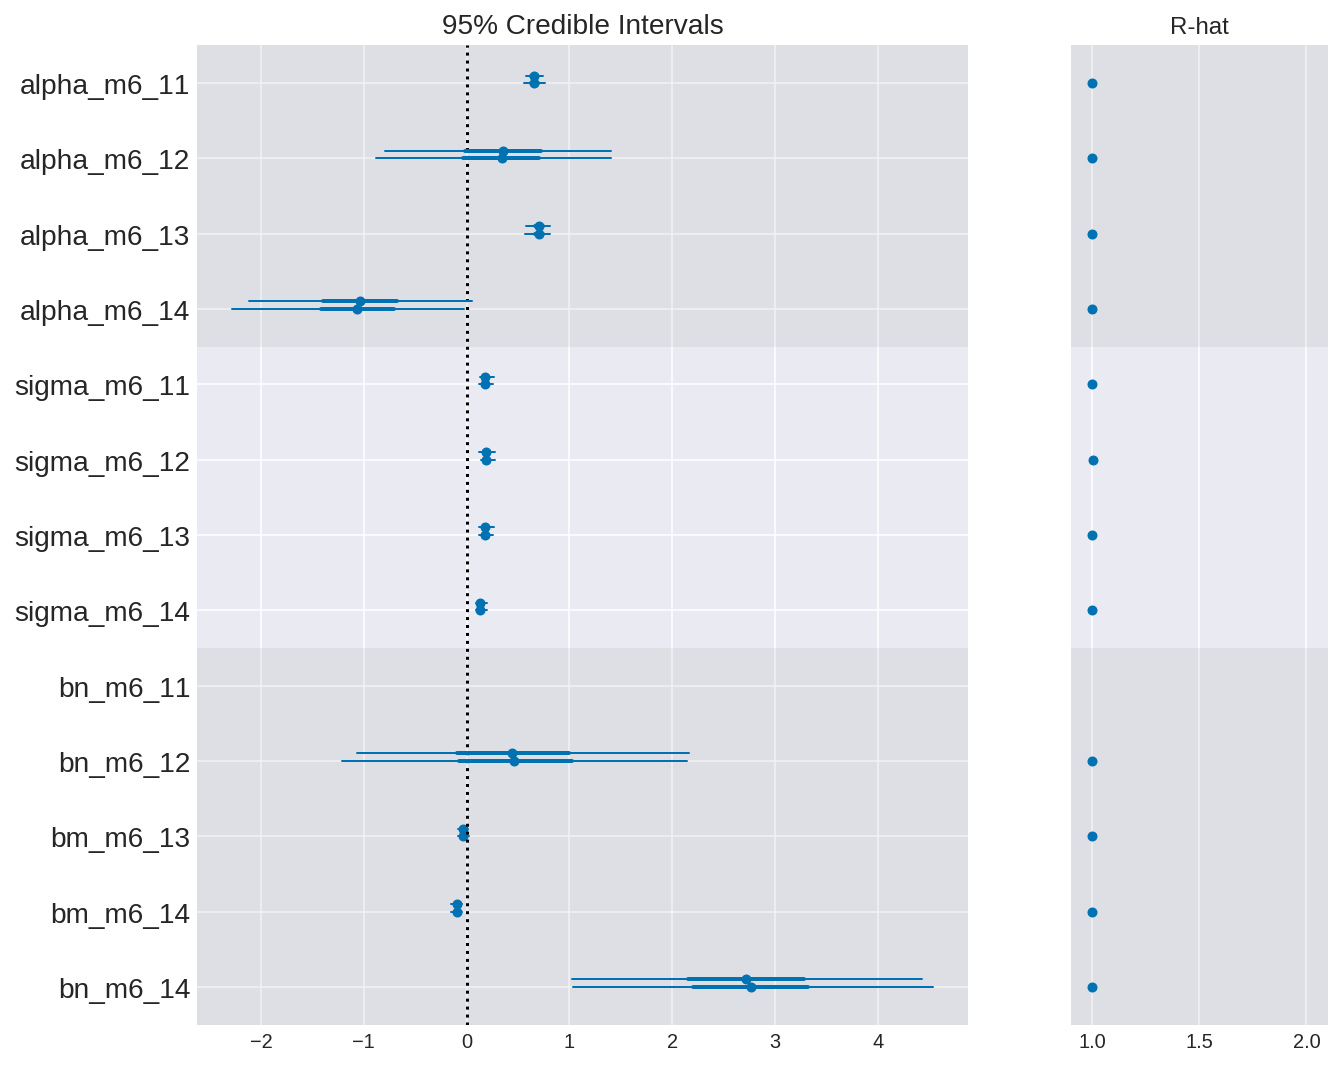

In [37]:
plt.figure(figsize=(10, 8))
ylabels = ['alpha_m6_11', 'alpha_m6_12', 'alpha_m6_13', 'alpha_m6_14',
           'sigma_m6_11', 'sigma_m6_12', 'sigma_m6_13', 'sigma_m6_14',
           'bn_m6_11', 'bn_m6_12', 'bm_m6_13', 'bm_m6_14', 'bn_m6_14']
pm.forestplot(traces, ylabels=ylabels, plot_kwargs={'fontsize':14});

#### Code 6.29

In [38]:
kcal_per_g = np.repeat(0, 30) # empty outcome
neocortex = np.linspace(0.5, 0.8, 30) # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass

In [39]:
mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_ppc(trace_m6_14, samples=10000, model=m6_14)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 10000/10000 [00:06<00:00, 1433.25it/s]


#### Code 6.30

In [40]:
milk_ensemble = pm.sample_ppc_w(traces, 10000, 
                                models, weights=compare_df.weight.sort_index(ascending=True))

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive_w()
  
100%|██████████| 10000/10000 [00:06<00:00, 1529.74it/s]


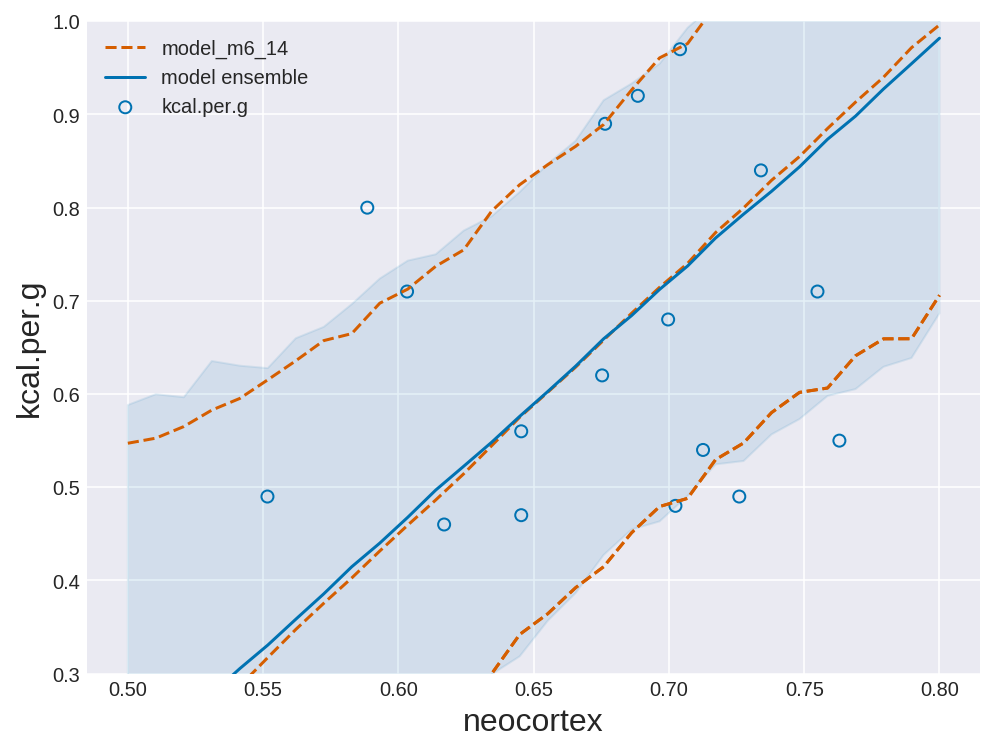

In [41]:
plt.figure(figsize=(8, 6))

plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='C2', label='model_m6_14')
hpd_post_pred = pm.hpd(post_pred['kcal'], alpha=0.1)
plt.plot(neocortex,hpd_post_pred[:,0], ls='--', color='C2')
plt.plot(neocortex,hpd_post_pred[:,], ls='--', color='C2')

plt.plot(neocortex, milk_ensemble['kcal'].mean(0), color='C0', label='model ensemble')
hpd_av = pm.hpd(milk_ensemble['kcal'], alpha=0.1)
plt.fill_between(neocortex, hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0.3, 1)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16)
plt.legend();

In [42]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
NumPy 1.16.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
